## Handling of CF time in *Pyaerocom*

The [ModelData](http://aerocom.met.no/pyaerocom/api.html#module-pyaerocom.modeldata) class of *Pyaerocom* was introduced in [this notebook](http://aerocom.met.no/pyaerocom/notebooks.html#introducing-the-modeldata-class). 

Here, we want to illustrate one particular feature of *Pyaerocom*, namely the conversion of CF conform numerical time stamps with a defined unit (i.e. basedate and calendar, see e.g. [here](http://cfconventions.org/Data/cf-conventions/cf-conventions-1.6/build/cf-conventions.html#time-coordinate) for details) into datetime-like objects that can be interpreted by tools such as [Pandas](https://pandas.pydata.org/). The easiest way to work with time stamps in model data is, to simply work on the internal numerical indices, avoiding the necessity to convert them into actual datetime objects. However, sometimes (e.g. if we want to extract and analyse a time-series of global average Aerosol optical densities), we wish to use third party libraries such as Pandas, which require the timestamps to be datetime-like objects.

This notebook illustrates how time is handled in the iris module, particularly in the [Cube](http://scitools.org.uk/iris/docs/v1.9.0/html/iris/iris/cube.html#iris.cube.Cube) class, which is the basic data representation object in the *Pyaerocom* `ModelData` class. In particular, it emphazises some peculiarities that can lead to complications and finally shows, how *Pyaerocom* circumvents these issues. We shall see, that this does not only reduce the risk of conversion Errors, bu even results in a quite significant performance boost when converting from numerical CF timestamps to `numpy.datetime64` time stamps.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pyaerocom

### Load and plot some example data 

Get and load test data file using the new pyaerocom interface (the underlying datatype of `ModelData` is `iris.cube.Cube`.

In [2]:
files = pyaerocom.io.testfiles.get()

fpath_ecmwf = files['models']['ecmwf_osuite']
fpath_aatsr = files['models']['aatsr_su_v4.3']

In [3]:
data_ecmwf = pyaerocom.ModelData(fpath_ecmwf, var_name="od550aer", model_id="ECMWF_OSUITE")
data_aatsr = pyaerocom.ModelData(fpath_aatsr, var_name="od550aer", model_id="AATSR")

Rolling longitudes to -180 -> 180 definition


Note that, if the longitudes are defined on a 0 -> 360 degree grid, they are automatically converted to -180 -> 180 (the case of the ECMWF data).

Now, let's have a quick look and see what is in there. 

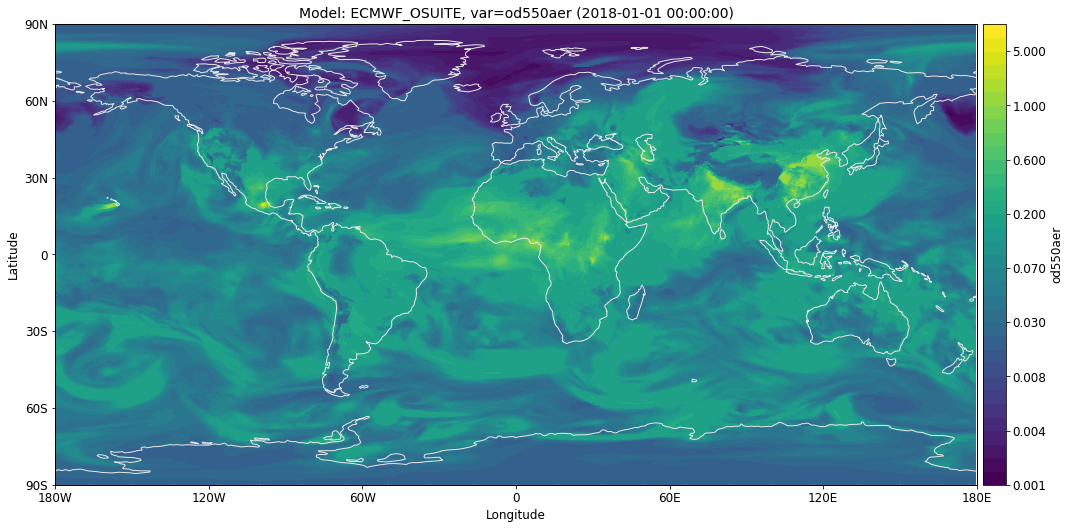

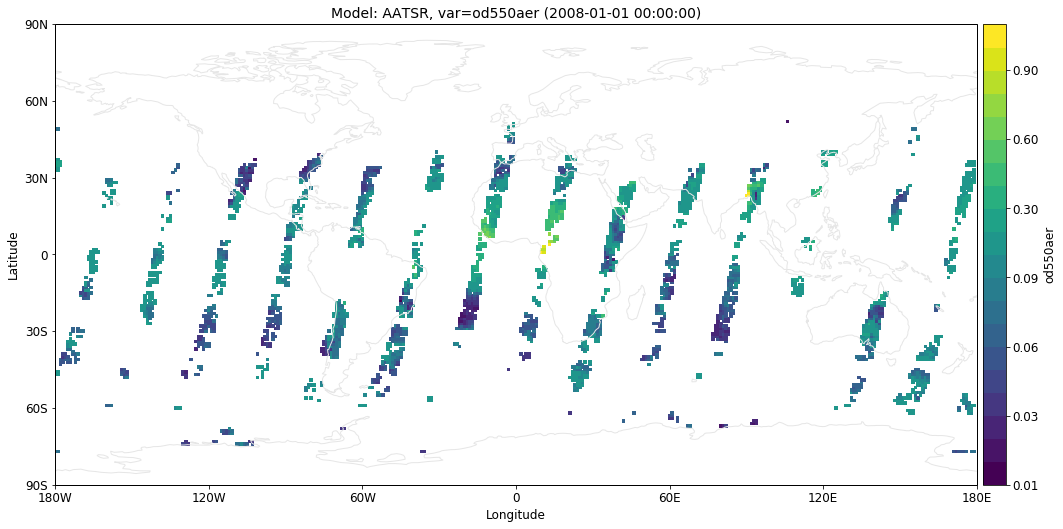

In [4]:
fig = data_ecmwf.quickplot_map()
fig2 = data_aatsr.quickplot_map()

### Digging into the time representation of iris Cubes

The `ModelData` class is based on the `iris.Cube` object, which can be accessed via the `grid` attribute. In the following, some features of the `Cube` class are introduced. 

In [5]:
cube_ecmwf = data_ecmwf.grid
cube_aatsr = data_aatsr.grid

#### Peculiarities of time handling when using the `Cube` interface

Starting with how time is handled. The time is represented as numerical value relative to a basic date and frequency  unit and in the optimum case, also the specification of a calendar, according to the [NetCDF CF conventions](http://cfconventions.org/Data/cf-conventions/cf-conventions-1.6/build/cf-conventions.html#time-coordinate).

In [6]:
times_ecmwf = cube_ecmwf.coord("time")
print("ECMWF\nFirst point:%s\nTime unit: %s\nCalendar: %s\n" %(times_ecmwf.points[0],
                                                               times_ecmwf.units.name, 
                                                               times_ecmwf.units.calendar))
times_aatsr= cube_aatsr.coord("time")
print("AATSR\nFirst point:%s\nTime unit: %s\nCalendar: %s\n" %(times_aatsr.points[0], 
                                                             times_aatsr.units.name, 
                                                             times_aatsr.units.calendar))

ECMWF
First point:0.0
Time unit: day since 2018-01-01 00:00:00.00000000 UTC
Calendar: gregorian

AATSR
First point:0.0
Time unit: day since 2008-01-01 00:00:00.00000000 UTC
Calendar: julian



Note that the AATSR data is defined using a Julian calendar. The actual time objects are instances of the `DimCoord` class of the iris package.

In [7]:
print(type(times_ecmwf), type(times_aatsr))

<class 'iris.coords.DimCoord'> <class 'iris.coords.DimCoord'>


Now, if we want to convert these numerically represented time stamps into datetime-like objects that, for instance, the `pandas` library understands, we have several options. The first one, which is the most obvious one, is using the provided iris interface which does the conversion for us, that is, using the `cell(index)` method (with the corresponding `index`) of the `DimCoord` class in combination with the `cells()` iterator method. However, as we shall see below, this is not only the slowest solution but it is also prone to errors in case the calendar is not standard (e.g. Julian).

In [8]:
t0_ecmwf = times_ecmwf.cell(0).point
t0_aatsr = times_aatsr.cell(0).point
print("First time stamp ECMWF %s (data type: %s)" %(t0_ecmwf, type(t0_ecmwf)))
print("First time stamp AATSR %s (data type: %s)" %(t0_aatsr, type(t0_aatsr)))

First time stamp ECMWF 2018-01-01 00:00:00 (data type: <class 'datetime.datetime'>)
First time stamp AATSR 2008-01-01 00:00:00 (data type: <class 'netcdftime._netcdftime.DatetimeJulian'>)


As you can see, the `cell` method returns different datatypes, dependent on the CF unit convention, that is, a standard Python `datetime.datetime` object, if the calendar is Gregorian, and a `netcdftime._netcdftime.DatetimeJulian` object in case of a Julian calendar. Problem here is, that the former is understood by pandas, while the latter is not.

In [9]:
import pandas

t0_ecmwf_pandas = pandas.Timestamp(t0_ecmwf)
try:
    t0_aatsr_pandas = pandas.Timestamp(t0_aatsr)
except TypeError as e:
    print(repr(e))

TypeError("Cannot convert input [2008-01-01 00:00:00] of type <class 'netcdftime._netcdftime.DatetimeJulian'> to Timestamp",)


Nontheless, numpy is easier in that sense, since it understands both datatypes.

In [10]:
import numpy as np

t0_ecmwf_np = np.datetime64(t0_ecmwf)
t0_aatsr_np = np.datetime64(t0_aatsr)
print(t0_ecmwf_np, t0_aatsr_np)

2018-01-01T00:00:00.000000 2008-01-01T00:00:00.000000


Fair enough, but however, in the end we want to ensure to have a conversion method ready that handles any calendar, and that is considerably fast. We just saw, that `datetime64` works for both datetime formats that we get when calling the `cell` method of the `DimCoord` object that holds the time stamps. However, keep in mind, that whenever `call` is called, it performs a conversion of the numeric value into either `datetime.datetime` or, for non-standard calendars, into a datetime object from the [cftime](https://github.com/Unidata/cftime) package. So, either way, when using the `cell` method we have to iterate over all indices to convert the numerical values into datetime-like objects. The latter may be done using the `cells()` iterator of the `DimCoord` class.

In [11]:
times_ecmwf_conv = [t.point for t in times_ecmwf.cells()]
times_aatsr_conv = [t.point for t in times_aatsr.cells()]
#display first two
print("%s\n\n%s" %(times_ecmwf_conv[:2],times_aatsr_conv[:2]))

[datetime.datetime(2018, 1, 1, 0, 0), datetime.datetime(2018, 1, 2, 0, 0)]

[netcdftime._netcdftime.DatetimeJulian(2008, 1, 1, 0, 0, 0, 0, -1, 1), netcdftime._netcdftime.DatetimeJulian(2008, 1, 2, 0, 0, 0, 0, -1, 1)]


This worked, but however, is it fast?

In [12]:
%%timeit 
[t.point for t in times_ecmwf.cells()]

129 ms ± 13.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
%%timeit
[t.point for t in times_aatsr.cells()]

111 ms ± 8.62 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


The answer is: No, it is not fast, and furthermore, the latter datatype will not be accepted by pandas as a valid datetime object. We can, however, convert the datapoints to numpy datetime64 objects during the conversion (if we want).

In [14]:
%%timeit 
[np.datetime64(t.point) for t in times_ecmwf.cells()]

184 ms ± 23.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
%%timeit
[np.datetime64(t.point) for t in times_aatsr.cells()]

114 ms ± 7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


That looks okay, since it does not lead to a notable decrease in the performance and ensures, that pandas will understand the datatype. However, about 100ms for conversion of 365 dates is rather slow.

#### Other options to convert timestamps 

Above we saw how we can convert the numerical timestamps into an array of numpy `datetime64` objects (which is what we want in the end). As we shall see below, the conversion can be significantly accelarated if we do not use the iris interface provided by the `cell(index)` method and the `cells()` iterator, but rather directly use the underlying `cftime` library (that iris uses).

In [16]:
%%timeit
[np.datetime64(t) for t in times_ecmwf.units.num2date(times_ecmwf.points)]

1.89 ms ± 186 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


This is quite an improvement. But if we dig a little deeper, we can boost this even more, as we shall see in the following. Basically, what it does is accessing the base date that is encrypted in the unit, i.e.

In [17]:
print(times_ecmwf.units.name)

day since 2018-01-01 00:00:00.00000000 UTC


and based on this base date, and the encrypted temporal resolution (here *day*) uses the [pure numpy datetime functionality](https://docs.scipy.org/doc/numpy-1.14.0/reference/arrays.datetime.html) to convert the stuff. For this, we have to test if the first sub string (here *day*) is valid according to the CF standard, which we do using some features from the `netCDF4` package and by defining a function, that translates the numerical timestamps into `datetime64` objects based on the information encoded in the units string(e.g. *day since 2018-01-01 00:00:00.00000000 UTC*) and the corresponding calendar (e.g. "gregorian").

In [18]:
from cf_units import Unit
from datetime import MINYEAR, datetime
from numpy import asarray, datetime64
from netCDF4 import (microsec_units, millisec_units, sec_units, min_units,
                    hr_units, day_units)
from netCDF4._netCDF4 import _dateparse
# Start of the gregorian calendar
# adapted from here: https://github.com/Unidata/cftime/blob/master/cftime/_cftime.pyx   
GREGORIAN_BASE = datetime(1582, 10, 15)

def cftime_to_datetime64(timesnum, cfunit, calendar=None):
    """Convert numerical timestamps with epoch to numpy datetime64
    
    This method was designed to enhance the performance of datetime conversions
    and is based on the corresponding information provided in the cftime 
    package (`see here <https://github.com/Unidata/cftime/blob/master/cftime/
    _cftime.pyx>`__). Particularly, this object does, what the :func:`num2date` 
    therein does, but faster, in case the time stamps are not defined on a non
    standard calendar.
    
    Parameters
    ----------
    timesnum : :obj:`list` or :obj:`ndarray`
        array containing numerical time stamps (relative to basedate of 
        ``cfunit``). Can also be a single number.
    cfunit : :obj:`str` or :obj:`Unit`
        CF unit string (e.g. day since 2018-01-01 00:00:00.00000000 UTC) or
        unit
    calendar : :obj:`str`, optional
        string specifying calendar (only required if ``cfunit`` is of type
        ``str``).
        
    Returns
    -------
    ndarray
        numpy array containing timestamps as datetime64 objects
        
    Raises
    ------
    ValueError
        if cfunit is ``str`` and calendar is not provided or invalid, or if 
        the cfunit string is invalid
        
    Example
    -------
    
    >>> cfunit_str = 'day since 2018-01-01 00:00:00.00000000 UTC'
    >>> cftime_to_datetime64(10, cfunit_str, "gregorian")
    array(['2018-01-11T00:00:00.000000'], dtype='datetime64[us]')
    """
    try:
        len(timesnum)
    except:
        timesnum = [timesnum]
    if isinstance(cfunit, str):
        if calendar is None:
            raise ValueError("Require specification of calendar for "
                             "conversion into datetime64 objects")
        cfunit = Unit(cfunit, calendar) #raises Error if calendar is invalid
    if not isinstance(cfunit, Unit):
        raise ValueError("Please provide cfunit either as instance of class "
                         "cf_units.Unit or as a string")
    cfu_str, calendar = cfunit.name, cfunit.calendar
    basedate = _dateparse(cfu_str)
    cfu_str = cfunit.name
    basedate = _dateparse(cfu_str)  
    if ((calendar == 'proleptic_gregorian' and basedate.year >= MINYEAR) or 
        (calendar in ['gregorian','standard'] and basedate > GREGORIAN_BASE)):
        cfu_str = cfunit.name
        res = cfu_str.split()[0].lower()
        if res in microsec_units:
            tstr = "us"
        elif res in millisec_units:
            tstr = "ms"
        elif res in sec_units:
            tstr = "s"
        elif res in min_units:
            tstr = "m"
        elif res in hr_units:
            tstr = "h"
        elif res in day_units:
            tstr = "D"
        else:
            raise ValueError('unsupported time units')
        
        basedate = datetime64(basedate)
        return basedate + asarray(timesnum, dtype="timedelta64[%s]" %tstr)
    else:
        return asarray([datetime64(t) for t in cfunit.num2date(timesnum)])

Now let's see how this one performs.

In [19]:
%%timeit
cftime_to_datetime64(times_ecmwf.points, times_ecmwf.units)

58.5 µs ± 1.25 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Actually, due to this significant increase in performance for standard calendars (compared to the methods used in netCDF4), the above method was implemented in the pyaerocom package ([see here](aerocom.met.no/pyaerocom/api.html#pyaerocom.helpers.cftime_to_datetime64)).

In [20]:
from pyaerocom.helpers import cftime_to_datetime64 as pyaerocom_tconversion

In [21]:
%%timeit
pyaerocom_tconversion(times_ecmwf.points, times_ecmwf.units)

63 µs ± 2.82 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


For the AATSR data, the method is slower, since here, the slower `num2date` method is used.

In [22]:
%%timeit
pyaerocom_tconversion(times_aatsr.points, times_aatsr.units)

1.76 ms ± 27.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Now this is an improvement. Starting with around 100ms when using the iris interface (i.e. iterating over `cells` of the `DimCoord`), for conversion of 365 time stamps, we ended up with the order of 10 microseconds. And at the same time the new method ensures that we have them in a format that also pandas understands. 

The method is also the standard conversion method in the `ModelData.time_stamps()` method:

In [23]:
%%timeit
data_ecmwf.time_stamps()

90 µs ± 4.76 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [24]:
%%timeit
data_aatsr.time_stamps()

1.93 ms ± 129 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
